<a href="https://colab.research.google.com/github/srikstanford/LWM/blob/main/lwm_v1p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Install required packages

In [ ]:
pip install DeepMIMOv3 umap-learn

2. Define the function that clones default datasets for downstream model training

In [ ]:
import subprocess
import os
import shutil

def clone_dataset_scenario(repo_url, model_repo_dir="./LWM", scenarios_dir="scenarios"):
    """
    Clones all scenarios from a repository, ensuring all files (small and large) are downloaded.

    Args:
        repo_url (str): URL of the Git repository
        model_repo_dir (str): Path to the model repository
        scenarios_dir (str): Directory name for storing scenarios
    """
    current_dir = os.path.basename(os.getcwd())
    if current_dir == "LWM":
        model_repo_dir = "."

    scenarios_path = os.path.join(model_repo_dir, scenarios_dir)
    os.makedirs(scenarios_path, exist_ok=True)

    original_dir = os.getcwd()

    try:
        if os.path.exists(scenarios_path):
            shutil.rmtree(scenarios_path)

        print("Cloning entire repository into temporary directory ...")
        subprocess.run([
            "git", "clone",
            repo_url,
            scenarios_path
        ], check=True)

        os.chdir(scenarios_path)

        print("Pulling all files using Git LFS ...")
        subprocess.run(["git", "lfs", "install"], check=True)
        subprocess.run(["git", "lfs", "pull"], check=True)

        print(f"Successfully cloned all scenarios into {scenarios_path}")

    except subprocess.CalledProcessError as e:
        print(f"Error cloning scenarios: {str(e)}")
    finally:
        if os.path.exists(scenarios_path):
            shutil.rmtree(scenarios_path)
        os.chdir(original_dir)

3. Clone the model repository

In [ ]:
# Step 1: Clone the model repository (if not already cloned)
model_repo_url = "https://huggingface.co/wi-lab/lwm-v1.1"
model_repo_dir = "./LWM-v1.1"

if not os.path.exists(model_repo_dir):
    print(f"Cloning model repository from {model_repo_url}...")
    subprocess.run(["git", "clone", model_repo_url, model_repo_dir], check=True)

Check the content in the repository

In [ ]:
ls ./LWM-v1.1

config.json    images/              lwm_model.py  __pycache__/  scenarios/
data/          inference.py         main.py       README.md     train.py
downstream.py  input_preprocess.py  models/       results/      utils.py


4. Clone the default datasets for downstream model training

In [ ]:
import numpy as np
dataset_repo_url = "https://huggingface.co/datasets/wi-lab/lwm"  # Base URL for dataset repo

# Clone the requested scenarios
clone_dataset_scenario(dataset_repo_url, model_repo_dir)

Cloning entire repository into temporary directory ...
Pulling all files using Git LFS ...
Successfully cloned all scenarios into ./LWM-v1.1/scenarios


Check the cloned DeepMIMO scenarios

In [ ]:
ls ./LWM-v1.1/scenarios

beam_prediction_challenge/  city_15_indianapolis/  city_6_miami/                  mmWave_scenarios/
city_11_santaclara/         city_18_denver/        city_7_sandiego/               README.md
city_12_fortworth/          city_19_oklahoma/      los_classification_challenge/  utils/


5. Change directory to LWM

In [ ]:
if os.path.exists(model_repo_dir):
    os.chdir(model_repo_dir)
    print(f"Changed working directory to {os.getcwd()}")
else:
    print(f"Directory {model_repo_dir} does not exist. Please check if the repository is cloned properly.")

Changed working directory to /content/LWM-v1.1


Make sure you are in the right directory

In [ ]:
ls

config.json    images/              lwm_model.py  __pycache__/  scenarios/
data/          inference.py         main.py       README.md     train.py
downstream.py  input_preprocess.py  models/       results/      utils.py


6. Import necessary packages and modules

In [ ]:
#%% IMPORT PACKAGES & MODULES
from input_preprocess import tokenizer, scenarios_list
from inference import lwm_inference
from utils import prepare_loaders
from train import finetune
import lwm_model
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

7. Choose your scenario, generate the scenario, and pass it through the preprocessing unit (The cell plot a figure based on the task you choose: For example, it shows line-of-sight/non-line-of-sight channels across the scenario layout). Additionally, you can choose your visualization method, input type, number of training samples, if you want to fine-tune LWM for a specific task, and the scenario. You can use your own scenario/dataset (make sure you normalize it before) by assigning the channel matrices to the 'amnual_data' argument in the 'tokenizer' function.


Generating data for scenario: city_6_miami, BS #3

Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 42984/42984 [00:04<00:00, 9042.09it/s]


Data saved to data/city_6_miami_ant16_sub32_bs3.npy
Total number of samples: 11688


Processing items: 100%|██████████| 11688/11688 [00:00<00:00, 12893.57it/s]


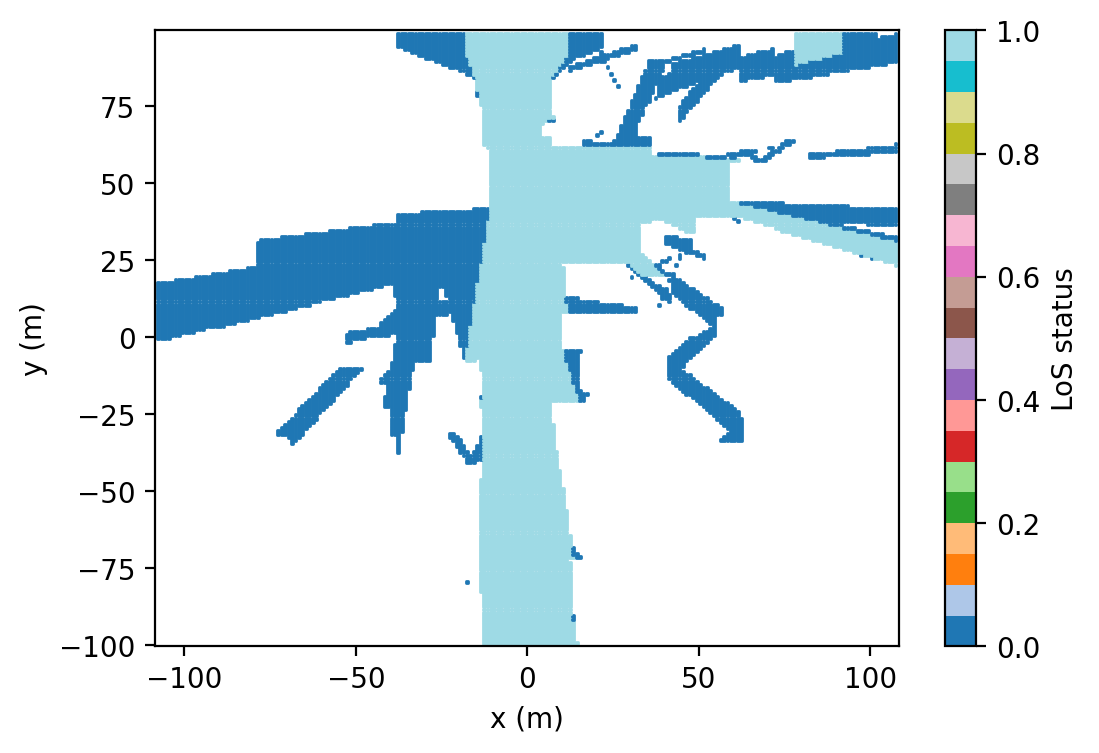

In [ ]:
#%% DOWNSTERAM DATA GENERATION
n_beams = 16
task = ['Beam Prediction', 'LoS/NLoS Classification'][1]
task_type = ["classification", "regression"][0]
visualization_method = ["pca", "umap", "tsne"][2]
input_types = ["cls_emb", "raw"] # ["cls_emb", "channel_emb", "raw"]
train_ratios = [[.001, .01, .05, .1, .25, .5, .8][0]]
fine_tuning_status = [[None, ["layers.9", "layers.10", "layers.11"], "full"][0]]
selected_scenario_names = [scenarios_list()[6]] # MIAMI DATASET: (16, 32) = 32 patches
preprocessed_data, labels, raw_chs = tokenizer(
    selected_scenario_names,
    bs_idxs=[3],
    load_data=False,
    task=task,
    n_beams=n_beams,
    manual_data=None)

8. Load the model

In [ ]:
#%% LOAD THE MODEL
gpu_ids = [0]
device = torch.device("cuda:0")
model = lwm_model.lwm().to(device)

model_name = "model.pth"
state_dict = torch.load(f"models/{model_name}", map_location=device)
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

model = nn.DataParallel(model, gpu_ids)
print(f"Model loaded successfully on GPU {device.index}")

Model loaded successfully on GPU 0


9. Perform inference on the chosen dataset and receive the respective embeddings. By turning visualization on, the space of original raw channels and their embeddings will be shown.

Inference: 100%|██████████| 183/183 [00:03<00:00, 53.97batch/s]


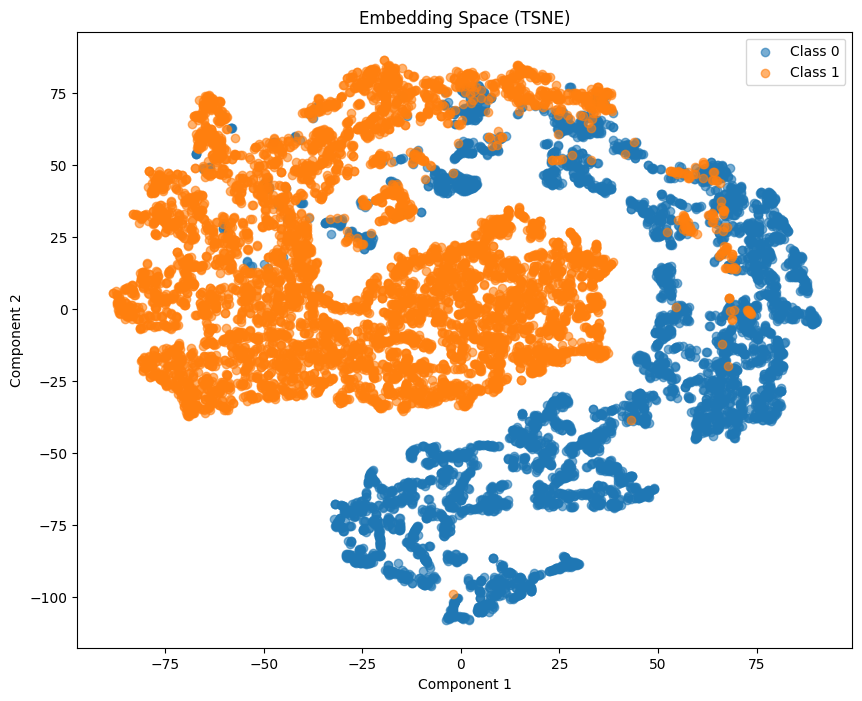

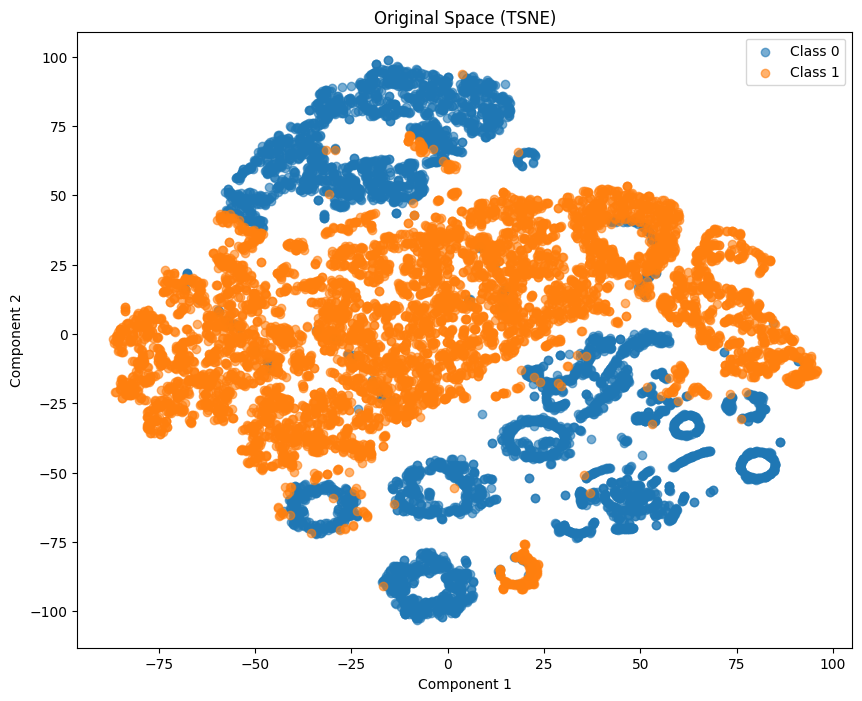

In [ ]:
#%% 2D EMBEDDING SPACE VISUALIZATIONN BEFORE FINE-TUNING
chs = lwm_inference(
    model,
    preprocessed_data,
    input_type="cls_emb",
    device=device,
    batch_size=64,
    visualization=True,
    labels=labels,
    visualization_method=visualization_method)

10. Based on the fine-tuning configuration you chose, this cell either only uses general-purpose LWM embeddings as the input to your downstream model or jointly fine-tunes the specified LWM layers with the downstream model. Although a default dowsntream model is defined, you can define your model manually in the train.py script.  

In the exmpale below, we have compared the performance of raw channels and their CLS embeddings in LoS/NLoS classification, using only 11 training samples.


fine-tuning status: None
input type: cls_emb
train ratio: 0.001

Train size: 11, Validation size: 11677
Number of head parameters: 232322


Epoch 1/150: 100%|██████████| 1/1 [00:00<00:00, 35.41it/s, Loss=0.797]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch1_valLoss0.6874_1742675197.pth with validation loss: 0.6874
Epoch 1, Validation F1-Score: 0.3658


Epoch 2/150: 100%|██████████| 1/1 [00:00<00:00, 41.41it/s, Loss=0.787]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch2_valLoss0.6861_1742675199.pth with validation loss: 0.6861
Epoch 2, Validation F1-Score: 0.3658


Epoch 3/150: 100%|██████████| 1/1 [00:00<00:00, 45.50it/s, Loss=0.784]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch3_valLoss0.6856_1742675200.pth with validation loss: 0.6856
Epoch 3, Validation F1-Score: 0.3658


Epoch 4/150: 100%|██████████| 1/1 [00:00<00:00, 29.57it/s, Loss=0.782]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch4_valLoss0.6846_1742675202.pth with validation loss: 0.6846
Epoch 4, Validation F1-Score: 0.3658


Epoch 5/150: 100%|██████████| 1/1 [00:00<00:00, 49.16it/s, Loss=0.64]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch5_valLoss0.6839_1742675203.pth with validation loss: 0.6839
Epoch 5, Validation F1-Score: 0.3658


Epoch 6/150: 100%|██████████| 1/1 [00:00<00:00, 33.90it/s, Loss=0.591]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch6_valLoss0.6826_1742675205.pth with validation loss: 0.6826
Epoch 6, Validation F1-Score: 0.3658


Epoch 7/150: 100%|██████████| 1/1 [00:00<00:00, 48.44it/s, Loss=0.61]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch7_valLoss0.6812_1742675206.pth with validation loss: 0.6812
Epoch 7, Validation F1-Score: 0.3658


Epoch 8/150: 100%|██████████| 1/1 [00:00<00:00, 42.84it/s, Loss=0.558]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch8_valLoss0.6800_1742675209.pth with validation loss: 0.6800
Epoch 8, Validation F1-Score: 0.3658


Epoch 9/150: 100%|██████████| 1/1 [00:00<00:00, 28.45it/s, Loss=0.548]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch9_valLoss0.6789_1742675210.pth with validation loss: 0.6789
Epoch 9, Validation F1-Score: 0.3658


Epoch 10/150: 100%|██████████| 1/1 [00:00<00:00, 41.20it/s, Loss=0.549]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch10_valLoss0.6775_1742675212.pth with validation loss: 0.6775
Epoch 10, Validation F1-Score: 0.3658


Epoch 11/150: 100%|██████████| 1/1 [00:00<00:00, 39.91it/s, Loss=0.518]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch11_valLoss0.6767_1742675213.pth with validation loss: 0.6767
Epoch 11, Validation F1-Score: 0.3658


Epoch 12/150: 100%|██████████| 1/1 [00:00<00:00, 44.06it/s, Loss=0.457]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch12_valLoss0.6758_1742675215.pth with validation loss: 0.6758
Epoch 12, Validation F1-Score: 0.3658


Epoch 13/150: 100%|██████████| 1/1 [00:00<00:00, 25.64it/s, Loss=0.431]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch13_valLoss0.6740_1742675216.pth with validation loss: 0.6740
Epoch 13, Validation F1-Score: 0.3658


Epoch 14/150: 100%|██████████| 1/1 [00:00<00:00, 42.77it/s, Loss=0.357]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch14_valLoss0.6726_1742675218.pth with validation loss: 0.6726
Epoch 14, Validation F1-Score: 0.3658


Epoch 15/150: 100%|██████████| 1/1 [00:00<00:00, 36.19it/s, Loss=0.431]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch15_valLoss0.6711_1742675220.pth with validation loss: 0.6711
Epoch 15, Validation F1-Score: 0.3658


Epoch 16/150: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s, Loss=0.359]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch16_valLoss0.6697_1742675222.pth with validation loss: 0.6697
Epoch 16, Validation F1-Score: 0.3658


Epoch 17/150: 100%|██████████| 1/1 [00:00<00:00, 42.67it/s, Loss=0.495]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch17_valLoss0.6679_1742675224.pth with validation loss: 0.6679
Epoch 17, Validation F1-Score: 0.3658


Epoch 18/150: 100%|██████████| 1/1 [00:00<00:00, 44.38it/s, Loss=0.431]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch18_valLoss0.6667_1742675225.pth with validation loss: 0.6667
Epoch 18, Validation F1-Score: 0.3658


Epoch 19/150: 100%|██████████| 1/1 [00:00<00:00, 45.39it/s, Loss=0.366]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch19_valLoss0.6646_1742675227.pth with validation loss: 0.6646
Epoch 19, Validation F1-Score: 0.3658


Epoch 20/150: 100%|██████████| 1/1 [00:00<00:00, 46.02it/s, Loss=0.354]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch20_valLoss0.6627_1742675228.pth with validation loss: 0.6627
Epoch 20, Validation F1-Score: 0.3658


Epoch 21/150: 100%|██████████| 1/1 [00:00<00:00, 26.74it/s, Loss=0.461]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch21_valLoss0.6615_1742675230.pth with validation loss: 0.6615
Epoch 21, Validation F1-Score: 0.3658


Epoch 22/150: 100%|██████████| 1/1 [00:00<00:00, 41.27it/s, Loss=0.31]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch22_valLoss0.6591_1742675232.pth with validation loss: 0.6591
Epoch 22, Validation F1-Score: 0.3658


Epoch 23/150: 100%|██████████| 1/1 [00:00<00:00, 34.73it/s, Loss=0.504]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch23_valLoss0.6569_1742675234.pth with validation loss: 0.6569
Epoch 23, Validation F1-Score: 0.3658


Epoch 24/150: 100%|██████████| 1/1 [00:00<00:00, 43.56it/s, Loss=0.392]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch24_valLoss0.6550_1742675235.pth with validation loss: 0.6550
Epoch 24, Validation F1-Score: 0.3658


Epoch 25/150: 100%|██████████| 1/1 [00:00<00:00, 42.98it/s, Loss=0.419]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch25_valLoss0.6524_1742675237.pth with validation loss: 0.6524
Epoch 25, Validation F1-Score: 0.3658


Epoch 26/150: 100%|██████████| 1/1 [00:00<00:00, 44.61it/s, Loss=0.434]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch26_valLoss0.6506_1742675238.pth with validation loss: 0.6506
Epoch 26, Validation F1-Score: 0.3658


Epoch 27/150: 100%|██████████| 1/1 [00:00<00:00, 47.41it/s, Loss=0.361]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch27_valLoss0.6478_1742675240.pth with validation loss: 0.6478
Epoch 27, Validation F1-Score: 0.3658


Epoch 28/150: 100%|██████████| 1/1 [00:00<00:00, 44.20it/s, Loss=0.382]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch28_valLoss0.6450_1742675241.pth with validation loss: 0.6450
Epoch 28, Validation F1-Score: 0.3658


Epoch 29/150: 100%|██████████| 1/1 [00:00<00:00, 42.52it/s, Loss=0.28]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch29_valLoss0.6412_1742675243.pth with validation loss: 0.6412
Epoch 29, Validation F1-Score: 0.3658


Epoch 30/150: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s, Loss=0.45]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch30_valLoss0.6395_1742675245.pth with validation loss: 0.6395
Epoch 30, Validation F1-Score: 0.3658


Epoch 31/150: 100%|██████████| 1/1 [00:00<00:00, 43.99it/s, Loss=0.45]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch31_valLoss0.6356_1742675247.pth with validation loss: 0.6356
Epoch 31, Validation F1-Score: 0.3658


Epoch 32/150: 100%|██████████| 1/1 [00:00<00:00, 45.82it/s, Loss=0.353]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch32_valLoss0.6320_1742675248.pth with validation loss: 0.6320
Epoch 32, Validation F1-Score: 0.3658


Epoch 33/150: 100%|██████████| 1/1 [00:00<00:00, 47.05it/s, Loss=0.341]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch33_valLoss0.6291_1742675250.pth with validation loss: 0.6291
Epoch 33, Validation F1-Score: 0.3658


Epoch 34/150: 100%|██████████| 1/1 [00:00<00:00, 46.31it/s, Loss=0.388]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch34_valLoss0.6255_1742675251.pth with validation loss: 0.6255
Epoch 34, Validation F1-Score: 0.3658


Epoch 35/150: 100%|██████████| 1/1 [00:00<00:00, 46.25it/s, Loss=0.386]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch35_valLoss0.6231_1742675253.pth with validation loss: 0.6231
Epoch 35, Validation F1-Score: 0.3658


Epoch 36/150: 100%|██████████| 1/1 [00:00<00:00, 43.34it/s, Loss=0.475]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch36_valLoss0.6174_1742675254.pth with validation loss: 0.6174
Epoch 36, Validation F1-Score: 0.3658


Epoch 37/150: 100%|██████████| 1/1 [00:00<00:00, 44.92it/s, Loss=0.376]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch37_valLoss0.6142_1742675256.pth with validation loss: 0.6142
Epoch 37, Validation F1-Score: 0.3658


Epoch 38/150: 100%|██████████| 1/1 [00:00<00:00, 27.23it/s, Loss=0.439]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch38_valLoss0.6113_1742675258.pth with validation loss: 0.6113
Epoch 38, Validation F1-Score: 0.3658


Epoch 39/150: 100%|██████████| 1/1 [00:00<00:00, 41.70it/s, Loss=0.416]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch39_valLoss0.6074_1742675260.pth with validation loss: 0.6074
Epoch 39, Validation F1-Score: 0.3658


Epoch 40/150: 100%|██████████| 1/1 [00:00<00:00, 44.97it/s, Loss=0.434]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch40_valLoss0.6028_1742675261.pth with validation loss: 0.6028
Epoch 40, Validation F1-Score: 0.3658


Epoch 41/150: 100%|██████████| 1/1 [00:00<00:00, 45.89it/s, Loss=0.381]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch41_valLoss0.5979_1742675263.pth with validation loss: 0.5979
Epoch 41, Validation F1-Score: 0.3658


Epoch 42/150: 100%|██████████| 1/1 [00:00<00:00, 41.91it/s, Loss=0.411]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch42_valLoss0.5955_1742675264.pth with validation loss: 0.5955
Epoch 42, Validation F1-Score: 0.3658


Epoch 43/150: 100%|██████████| 1/1 [00:00<00:00, 41.37it/s, Loss=0.524]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch43_valLoss0.5921_1742675266.pth with validation loss: 0.5921
Epoch 43, Validation F1-Score: 0.3658


Epoch 44/150: 100%|██████████| 1/1 [00:00<00:00, 41.55it/s, Loss=0.39]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch44_valLoss0.5863_1742675268.pth with validation loss: 0.5863
Epoch 44, Validation F1-Score: 0.3658


Epoch 45/150: 100%|██████████| 1/1 [00:00<00:00, 34.99it/s, Loss=0.552]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch45_valLoss0.5798_1742675270.pth with validation loss: 0.5798
Epoch 45, Validation F1-Score: 0.3658


Epoch 46/150: 100%|██████████| 1/1 [00:00<00:00, 43.66it/s, Loss=0.417]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch46_valLoss0.5759_1742675271.pth with validation loss: 0.5759
Epoch 46, Validation F1-Score: 0.3658


Epoch 47/150: 100%|██████████| 1/1 [00:00<00:00, 46.71it/s, Loss=0.359]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch47_valLoss0.5713_1742675273.pth with validation loss: 0.5713
Epoch 47, Validation F1-Score: 0.3658


Epoch 48/150: 100%|██████████| 1/1 [00:00<00:00, 46.21it/s, Loss=0.392]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch48_valLoss0.5662_1742675274.pth with validation loss: 0.5662
Epoch 48, Validation F1-Score: 0.3658


Epoch 49/150: 100%|██████████| 1/1 [00:00<00:00, 45.53it/s, Loss=0.503]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch49_valLoss0.5624_1742675276.pth with validation loss: 0.5624
Epoch 49, Validation F1-Score: 0.3658


Epoch 50/150: 100%|██████████| 1/1 [00:00<00:00, 42.83it/s, Loss=0.449]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch50_valLoss0.5567_1742675277.pth with validation loss: 0.5567
Epoch 50, Validation F1-Score: 0.3658


Epoch 51/150: 100%|██████████| 1/1 [00:00<00:00, 43.41it/s, Loss=0.344]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch51_valLoss0.5483_1742675279.pth with validation loss: 0.5483
Epoch 51, Validation F1-Score: 0.4561


Epoch 52/150: 100%|██████████| 1/1 [00:00<00:00, 33.24it/s, Loss=0.462]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch52_valLoss0.5421_1742675281.pth with validation loss: 0.5421
Epoch 52, Validation F1-Score: 0.5810


Epoch 53/150: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s, Loss=0.444]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch53_valLoss0.5352_1742675283.pth with validation loss: 0.5352
Epoch 53, Validation F1-Score: 0.5988


Epoch 54/150: 100%|██████████| 1/1 [00:00<00:00, 45.25it/s, Loss=0.426]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch54_valLoss0.5298_1742675284.pth with validation loss: 0.5298
Epoch 54, Validation F1-Score: 0.6000


Epoch 55/150: 100%|██████████| 1/1 [00:00<00:00, 44.04it/s, Loss=0.403]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch55_valLoss0.5224_1742675286.pth with validation loss: 0.5224
Epoch 55, Validation F1-Score: 0.6341


Epoch 56/150: 100%|██████████| 1/1 [00:00<00:00, 42.20it/s, Loss=0.409]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch56_valLoss0.5153_1742675287.pth with validation loss: 0.5153
Epoch 56, Validation F1-Score: 0.6404


Epoch 57/150: 100%|██████████| 1/1 [00:00<00:00, 45.33it/s, Loss=0.443]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch57_valLoss0.5109_1742675289.pth with validation loss: 0.5109
Epoch 57, Validation F1-Score: 0.6290


Epoch 58/150: 100%|██████████| 1/1 [00:00<00:00, 43.86it/s, Loss=0.388]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch58_valLoss0.5040_1742675290.pth with validation loss: 0.5040
Epoch 58, Validation F1-Score: 0.6794


Epoch 59/150: 100%|██████████| 1/1 [00:00<00:00, 41.84it/s, Loss=0.361]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch59_valLoss0.4977_1742675292.pth with validation loss: 0.4977
Epoch 59, Validation F1-Score: 0.7002


Epoch 60/150: 100%|██████████| 1/1 [00:00<00:00, 33.82it/s, Loss=0.416]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch60_valLoss0.4938_1742675294.pth with validation loss: 0.4938
Epoch 60, Validation F1-Score: 0.6973


Epoch 61/150: 100%|██████████| 1/1 [00:00<00:00, 44.32it/s, Loss=0.423]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch61_valLoss0.4875_1742675296.pth with validation loss: 0.4875
Epoch 61, Validation F1-Score: 0.7309


Epoch 62/150: 100%|██████████| 1/1 [00:00<00:00, 42.72it/s, Loss=0.479]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch62_valLoss0.4822_1742675297.pth with validation loss: 0.4822
Epoch 62, Validation F1-Score: 0.7368


Epoch 63/150: 100%|██████████| 1/1 [00:00<00:00, 43.42it/s, Loss=0.296]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch63_valLoss0.4756_1742675299.pth with validation loss: 0.4756
Epoch 63, Validation F1-Score: 0.7658


Epoch 64/150: 100%|██████████| 1/1 [00:00<00:00, 42.84it/s, Loss=0.467]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch64_valLoss0.4694_1742675300.pth with validation loss: 0.4694
Epoch 64, Validation F1-Score: 0.7971


Epoch 65/150: 100%|██████████| 1/1 [00:00<00:00, 44.62it/s, Loss=0.394]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch65_valLoss0.4603_1742675302.pth with validation loss: 0.4603
Epoch 65, Validation F1-Score: 0.8384


Epoch 66/150: 100%|██████████| 1/1 [00:00<00:00, 42.92it/s, Loss=0.358]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch66_valLoss0.4530_1742675304.pth with validation loss: 0.4530
Epoch 66, Validation F1-Score: 0.8405


Epoch 67/150: 100%|██████████| 1/1 [00:00<00:00, 29.86it/s, Loss=0.459]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch67_valLoss0.4499_1742675306.pth with validation loss: 0.4499
Epoch 67, Validation F1-Score: 0.8204


Epoch 68/150: 100%|██████████| 1/1 [00:00<00:00, 44.15it/s, Loss=0.396]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch68_valLoss0.4417_1742675307.pth with validation loss: 0.4417
Epoch 68, Validation F1-Score: 0.8376


Epoch 69/150: 100%|██████████| 1/1 [00:00<00:00, 46.21it/s, Loss=0.329]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch69_valLoss0.4381_1742675309.pth with validation loss: 0.4381
Epoch 69, Validation F1-Score: 0.8497


Epoch 70/150: 100%|██████████| 1/1 [00:00<00:00, 45.91it/s, Loss=0.424]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch70_valLoss0.4307_1742675310.pth with validation loss: 0.4307
Epoch 70, Validation F1-Score: 0.8557


Epoch 71/150: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s, Loss=0.394]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch71_valLoss0.4269_1742675312.pth with validation loss: 0.4269
Epoch 71, Validation F1-Score: 0.8585


Epoch 72/150: 100%|██████████| 1/1 [00:00<00:00, 43.20it/s, Loss=0.37]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch72_valLoss0.4256_1742675314.pth with validation loss: 0.4256
Epoch 72, Validation F1-Score: 0.8527


Epoch 73/150: 100%|██████████| 1/1 [00:00<00:00, 47.30it/s, Loss=0.386]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch73_valLoss0.4217_1742675315.pth with validation loss: 0.4217
Epoch 73, Validation F1-Score: 0.8483


Epoch 74/150: 100%|██████████| 1/1 [00:00<00:00, 41.71it/s, Loss=0.422]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch74_valLoss0.4133_1742675317.pth with validation loss: 0.4133
Epoch 74, Validation F1-Score: 0.8544


Epoch 75/150: 100%|██████████| 1/1 [00:00<00:00, 31.38it/s, Loss=0.395]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch75_valLoss0.4089_1742675319.pth with validation loss: 0.4089
Epoch 75, Validation F1-Score: 0.8617


Epoch 76/150: 100%|██████████| 1/1 [00:00<00:00, 44.50it/s, Loss=0.36]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch76_valLoss0.4041_1742675320.pth with validation loss: 0.4041
Epoch 76, Validation F1-Score: 0.8676


Epoch 77/150: 100%|██████████| 1/1 [00:00<00:00, 41.27it/s, Loss=0.35]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch77_valLoss0.3993_1742675322.pth with validation loss: 0.3993
Epoch 77, Validation F1-Score: 0.8712


Epoch 78/150: 100%|██████████| 1/1 [00:00<00:00, 47.35it/s, Loss=0.423]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch78_valLoss0.3944_1742675323.pth with validation loss: 0.3944
Epoch 78, Validation F1-Score: 0.8829


Epoch 79/150: 100%|██████████| 1/1 [00:00<00:00, 47.53it/s, Loss=0.487]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch79_valLoss0.3896_1742675325.pth with validation loss: 0.3896
Epoch 79, Validation F1-Score: 0.8775


Epoch 80/150: 100%|██████████| 1/1 [00:00<00:00, 44.30it/s, Loss=0.447]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch80_valLoss0.3866_1742675326.pth with validation loss: 0.3866
Epoch 80, Validation F1-Score: 0.8723


Epoch 81/150: 100%|██████████| 1/1 [00:00<00:00, 43.13it/s, Loss=0.326]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch81_valLoss0.3795_1742675328.pth with validation loss: 0.3795
Epoch 81, Validation F1-Score: 0.8809


Epoch 82/150: 100%|██████████| 1/1 [00:00<00:00, 30.16it/s, Loss=0.436]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch82_valLoss0.3768_1742675330.pth with validation loss: 0.3768
Epoch 82, Validation F1-Score: 0.8847


Epoch 83/150: 100%|██████████| 1/1 [00:00<00:00, 33.72it/s, Loss=0.459]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch83_valLoss0.3737_1742675332.pth with validation loss: 0.3737
Epoch 83, Validation F1-Score: 0.8853


Epoch 84/150: 100%|██████████| 1/1 [00:00<00:00, 37.94it/s, Loss=0.436]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch84_valLoss0.3702_1742675333.pth with validation loss: 0.3702
Epoch 84, Validation F1-Score: 0.8909


Epoch 85/150: 100%|██████████| 1/1 [00:00<00:00, 46.00it/s, Loss=0.376]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch85_valLoss0.3653_1742675335.pth with validation loss: 0.3653
Epoch 85, Validation F1-Score: 0.8930


Epoch 86/150: 100%|██████████| 1/1 [00:00<00:00, 37.63it/s, Loss=0.394]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch86_valLoss0.3615_1742675336.pth with validation loss: 0.3615
Epoch 86, Validation F1-Score: 0.8980


Epoch 87/150: 100%|██████████| 1/1 [00:00<00:00, 45.10it/s, Loss=0.283]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch87_valLoss0.3579_1742675338.pth with validation loss: 0.3579
Epoch 87, Validation F1-Score: 0.9039


Epoch 88/150: 100%|██████████| 1/1 [00:00<00:00, 41.74it/s, Loss=0.368]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch88_valLoss0.3559_1742675340.pth with validation loss: 0.3559
Epoch 88, Validation F1-Score: 0.8967


Epoch 89/150: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s, Loss=0.319]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch89_valLoss0.3552_1742675342.pth with validation loss: 0.3552
Epoch 89, Validation F1-Score: 0.8995


Epoch 90/150: 100%|██████████| 1/1 [00:00<00:00, 26.20it/s, Loss=0.401]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch90_valLoss0.3529_1742675343.pth with validation loss: 0.3529
Epoch 90, Validation F1-Score: 0.9056


Epoch 91/150: 100%|██████████| 1/1 [00:00<00:00, 45.44it/s, Loss=0.391]


Epoch 91, Validation F1-Score: 0.8981


Epoch 92/150: 100%|██████████| 1/1 [00:00<00:00, 37.96it/s, Loss=0.421]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch92_valLoss0.3521_1742675346.pth with validation loss: 0.3521
Epoch 92, Validation F1-Score: 0.8965


Epoch 93/150: 100%|██████████| 1/1 [00:00<00:00, 48.05it/s, Loss=0.34]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch93_valLoss0.3464_1742675348.pth with validation loss: 0.3464
Epoch 93, Validation F1-Score: 0.9089


Epoch 94/150: 100%|██████████| 1/1 [00:00<00:00, 40.33it/s, Loss=0.351]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch94_valLoss0.3437_1742675349.pth with validation loss: 0.3437
Epoch 94, Validation F1-Score: 0.9045


Epoch 95/150: 100%|██████████| 1/1 [00:00<00:00, 42.57it/s, Loss=0.408]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch95_valLoss0.3418_1742675351.pth with validation loss: 0.3418
Epoch 95, Validation F1-Score: 0.9069


Epoch 96/150: 100%|██████████| 1/1 [00:00<00:00, 32.40it/s, Loss=0.407]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch96_valLoss0.3394_1742675353.pth with validation loss: 0.3394
Epoch 96, Validation F1-Score: 0.9016


Epoch 97/150: 100%|██████████| 1/1 [00:00<00:00, 36.52it/s, Loss=0.421]


Epoch 97, Validation F1-Score: 0.8993


Epoch 98/150: 100%|██████████| 1/1 [00:00<00:00, 38.23it/s, Loss=0.409]


Epoch 98, Validation F1-Score: 0.9040


Epoch 99/150: 100%|██████████| 1/1 [00:00<00:00, 45.25it/s, Loss=0.428]


Epoch 99, Validation F1-Score: 0.8971


Epoch 100/150: 100%|██████████| 1/1 [00:00<00:00, 41.45it/s, Loss=0.41]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch100_valLoss0.3382_1742675359.pth with validation loss: 0.3382
Epoch 100, Validation F1-Score: 0.8981


Epoch 101/150: 100%|██████████| 1/1 [00:00<00:00, 44.39it/s, Loss=0.401]


Epoch 101, Validation F1-Score: 0.8979


Epoch 102/150: 100%|██████████| 1/1 [00:00<00:00, 38.05it/s, Loss=0.377]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch102_valLoss0.3379_1742675362.pth with validation loss: 0.3379
Epoch 102, Validation F1-Score: 0.9065


Epoch 103/150: 100%|██████████| 1/1 [00:00<00:00, 42.11it/s, Loss=0.364]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch103_valLoss0.3379_1742675364.pth with validation loss: 0.3379
Epoch 103, Validation F1-Score: 0.9096


Epoch 104/150: 100%|██████████| 1/1 [00:00<00:00, 25.84it/s, Loss=0.431]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch104_valLoss0.3344_1742675366.pth with validation loss: 0.3344
Epoch 104, Validation F1-Score: 0.9131


Epoch 105/150: 100%|██████████| 1/1 [00:00<00:00, 41.20it/s, Loss=0.444]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch105_valLoss0.3337_1742675368.pth with validation loss: 0.3337
Epoch 105, Validation F1-Score: 0.9125


Epoch 106/150: 100%|██████████| 1/1 [00:00<00:00, 47.26it/s, Loss=0.371]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch106_valLoss0.3332_1742675369.pth with validation loss: 0.3332
Epoch 106, Validation F1-Score: 0.9087


Epoch 107/150: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s, Loss=0.351]


Epoch 107, Validation F1-Score: 0.9125


Epoch 108/150: 100%|██████████| 1/1 [00:00<00:00, 44.54it/s, Loss=0.416]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch108_valLoss0.3320_1742675372.pth with validation loss: 0.3320
Epoch 108, Validation F1-Score: 0.9139


Epoch 109/150: 100%|██████████| 1/1 [00:00<00:00, 46.42it/s, Loss=0.399]


Epoch 109, Validation F1-Score: 0.9139


Epoch 110/150: 100%|██████████| 1/1 [00:00<00:00, 48.21it/s, Loss=0.415]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch110_valLoss0.3307_1742675375.pth with validation loss: 0.3307
Epoch 110, Validation F1-Score: 0.9138


Epoch 111/150: 100%|██████████| 1/1 [00:00<00:00, 41.38it/s, Loss=0.447]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch111_valLoss0.3302_1742675377.pth with validation loss: 0.3302
Epoch 111, Validation F1-Score: 0.9102


Epoch 112/150: 100%|██████████| 1/1 [00:00<00:00, 24.78it/s, Loss=0.476]


Epoch 112, Validation F1-Score: 0.9106


Epoch 113/150: 100%|██████████| 1/1 [00:00<00:00, 42.22it/s, Loss=0.376]


Epoch 113, Validation F1-Score: 0.9079


Epoch 114/150: 100%|██████████| 1/1 [00:00<00:00, 43.53it/s, Loss=0.47]


Epoch 114, Validation F1-Score: 0.9029


Epoch 115/150: 100%|██████████| 1/1 [00:00<00:00, 38.22it/s, Loss=0.454]


Epoch 115, Validation F1-Score: 0.9011


Epoch 116/150: 100%|██████████| 1/1 [00:00<00:00, 41.60it/s, Loss=0.378]


Epoch 116, Validation F1-Score: 0.9100


Epoch 117/150: 100%|██████████| 1/1 [00:00<00:00, 30.01it/s, Loss=0.375]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch117_valLoss0.3283_1742675387.pth with validation loss: 0.3283
Epoch 117, Validation F1-Score: 0.9110


Epoch 118/150: 100%|██████████| 1/1 [00:00<00:00, 42.12it/s, Loss=0.369]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch118_valLoss0.3273_1742675388.pth with validation loss: 0.3273
Epoch 118, Validation F1-Score: 0.9134


Epoch 119/150: 100%|██████████| 1/1 [00:00<00:00, 36.08it/s, Loss=0.308]


Epoch 119, Validation F1-Score: 0.9073


Epoch 120/150: 100%|██████████| 1/1 [00:00<00:00, 43.78it/s, Loss=0.579]


Epoch 120, Validation F1-Score: 0.9065


Epoch 121/150: 100%|██████████| 1/1 [00:00<00:00, 39.38it/s, Loss=0.318]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch121_valLoss0.3273_1742675393.pth with validation loss: 0.3273
Epoch 121, Validation F1-Score: 0.9115


Epoch 122/150: 100%|██████████| 1/1 [00:00<00:00, 44.92it/s, Loss=0.436]


Epoch 122, Validation F1-Score: 0.9078


Epoch 123/150: 100%|██████████| 1/1 [00:00<00:00, 38.09it/s, Loss=0.381]


Epoch 123, Validation F1-Score: 0.8997


Epoch 124/150: 100%|██████████| 1/1 [00:00<00:00, 42.12it/s, Loss=0.435]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch124_valLoss0.3233_1742675398.pth with validation loss: 0.3233
Epoch 124, Validation F1-Score: 0.9077


Epoch 125/150: 100%|██████████| 1/1 [00:00<00:00, 41.24it/s, Loss=0.419]


Epoch 125, Validation F1-Score: 0.9076


Epoch 126/150: 100%|██████████| 1/1 [00:00<00:00, 44.44it/s, Loss=0.321]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch126_valLoss0.3205_1742675401.pth with validation loss: 0.3205
Epoch 126, Validation F1-Score: 0.9093


Epoch 127/150: 100%|██████████| 1/1 [00:00<00:00, 36.95it/s, Loss=0.492]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch127_valLoss0.3201_1742675403.pth with validation loss: 0.3201
Epoch 127, Validation F1-Score: 0.9046


Epoch 128/150: 100%|██████████| 1/1 [00:00<00:00, 44.09it/s, Loss=0.406]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch128_valLoss0.3197_1742675405.pth with validation loss: 0.3197
Epoch 128, Validation F1-Score: 0.9079


Epoch 129/150: 100%|██████████| 1/1 [00:00<00:00, 43.03it/s, Loss=0.429]


Model saved at results/LoS/NLoS Classification/1742675195/cls_emb_epoch129_valLoss0.3185_1742675406.pth with validation loss: 0.3185
Epoch 129, Validation F1-Score: 0.9100


Epoch 130/150: 100%|██████████| 1/1 [00:00<00:00, 40.67it/s, Loss=0.36]


Epoch 130, Validation F1-Score: 0.9051


Epoch 131/150: 100%|██████████| 1/1 [00:00<00:00, 30.86it/s, Loss=0.384]


Epoch 131, Validation F1-Score: 0.9090


Epoch 132/150: 100%|██████████| 1/1 [00:00<00:00, 34.88it/s, Loss=0.402]


Epoch 132, Validation F1-Score: 0.9088


Epoch 133/150: 100%|██████████| 1/1 [00:00<00:00, 40.42it/s, Loss=0.409]


Epoch 133, Validation F1-Score: 0.9115


Epoch 134/150: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s, Loss=0.397]


Epoch 134, Validation F1-Score: 0.9059


Epoch 135/150: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s, Loss=0.312]


Epoch 135, Validation F1-Score: 0.8929


Epoch 136/150: 100%|██████████| 1/1 [00:00<00:00, 42.06it/s, Loss=0.449]


Epoch 136, Validation F1-Score: 0.9003


Epoch 137/150: 100%|██████████| 1/1 [00:00<00:00, 42.93it/s, Loss=0.463]


Epoch 137, Validation F1-Score: 0.9012


Epoch 138/150: 100%|██████████| 1/1 [00:00<00:00, 35.25it/s, Loss=0.429]


Epoch 138, Validation F1-Score: 0.9088


Epoch 139/150: 100%|██████████| 1/1 [00:00<00:00, 44.75it/s, Loss=0.419]


Epoch 139, Validation F1-Score: 0.9057


Epoch 140/150: 100%|██████████| 1/1 [00:00<00:00, 42.96it/s, Loss=0.511]


Epoch 140, Validation F1-Score: 0.9027


Epoch 141/150: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s, Loss=0.341]


Epoch 141, Validation F1-Score: 0.9063


Epoch 142/150: 100%|██████████| 1/1 [00:00<00:00, 34.26it/s, Loss=0.343]


Epoch 142, Validation F1-Score: 0.9019


Epoch 143/150: 100%|██████████| 1/1 [00:00<00:00, 39.59it/s, Loss=0.357]


Epoch 143, Validation F1-Score: 0.8940


Epoch 144/150: 100%|██████████| 1/1 [00:00<00:00, 42.97it/s, Loss=0.34]


Epoch 144, Validation F1-Score: 0.8812


Epoch 145/150: 100%|██████████| 1/1 [00:00<00:00, 47.21it/s, Loss=0.409]


Epoch 145, Validation F1-Score: 0.8815


Epoch 146/150: 100%|██████████| 1/1 [00:00<00:00, 45.65it/s, Loss=0.379]


Epoch 146, Validation F1-Score: 0.8877


Epoch 147/150: 100%|██████████| 1/1 [00:00<00:00, 42.49it/s, Loss=0.309]


Epoch 147, Validation F1-Score: 0.8807


Epoch 148/150: 100%|██████████| 1/1 [00:00<00:00, 47.55it/s, Loss=0.415]


Epoch 148, Validation F1-Score: 0.8808


Epoch 149/150: 100%|██████████| 1/1 [00:00<00:00, 41.51it/s, Loss=0.417]


Epoch 149, Validation F1-Score: 0.8789


Epoch 150/150: 100%|██████████| 1/1 [00:00<00:00, 29.96it/s, Loss=0.367]


Epoch 150, Validation F1-Score: 0.8879


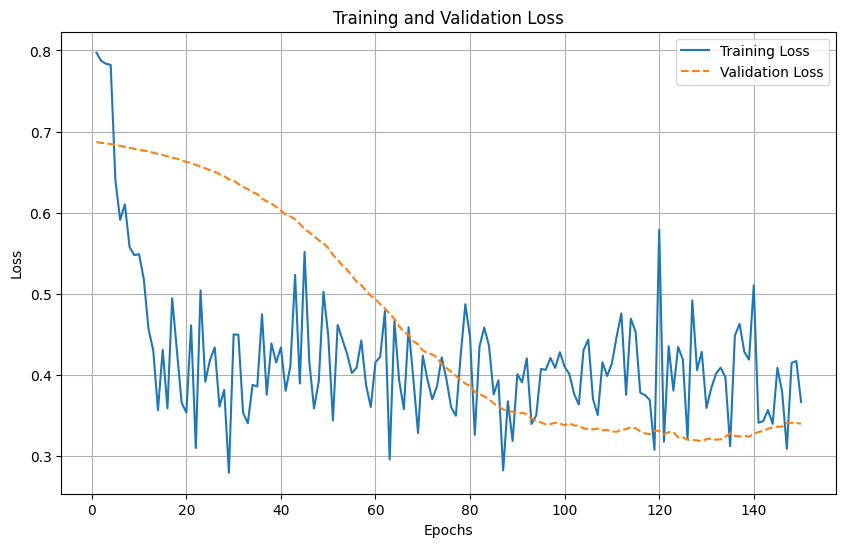


fine-tuning status: None
input type: raw
train ratio: 0.001

Train size: 11, Validation size: 11677
Number of head parameters: 691074


Epoch 1/150: 100%|██████████| 1/1 [00:00<00:00, 93.07it/s, Loss=0.697]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch1_valLoss0.7649_1742675440.pth with validation loss: 0.7649
Epoch 1, Validation F1-Score: 0.4635


Epoch 2/150: 100%|██████████| 1/1 [00:00<00:00, 95.25it/s, Loss=0.488]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch2_valLoss0.7351_1742675440.pth with validation loss: 0.7351
Epoch 2, Validation F1-Score: 0.5256


Epoch 3/150: 100%|██████████| 1/1 [00:00<00:00, 110.45it/s, Loss=0.438]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch3_valLoss0.7174_1742675441.pth with validation loss: 0.7174
Epoch 3, Validation F1-Score: 0.5749


Epoch 4/150: 100%|██████████| 1/1 [00:00<00:00, 64.91it/s, Loss=0.365]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch4_valLoss0.7036_1742675441.pth with validation loss: 0.7036
Epoch 4, Validation F1-Score: 0.6098


Epoch 5/150: 100%|██████████| 1/1 [00:00<00:00, 110.10it/s, Loss=0.273]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch5_valLoss0.6916_1742675441.pth with validation loss: 0.6916
Epoch 5, Validation F1-Score: 0.6348


Epoch 6/150: 100%|██████████| 1/1 [00:00<00:00, 95.08it/s, Loss=0.271]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch6_valLoss0.6809_1742675441.pth with validation loss: 0.6809
Epoch 6, Validation F1-Score: 0.6482


Epoch 7/150: 100%|██████████| 1/1 [00:00<00:00, 72.86it/s, Loss=0.292]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch7_valLoss0.6689_1742675442.pth with validation loss: 0.6689
Epoch 7, Validation F1-Score: 0.6641


Epoch 8/150: 100%|██████████| 1/1 [00:00<00:00, 112.83it/s, Loss=0.233]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch8_valLoss0.6590_1742675442.pth with validation loss: 0.6590
Epoch 8, Validation F1-Score: 0.6690


Epoch 9/150: 100%|██████████| 1/1 [00:00<00:00, 84.83it/s, Loss=0.206]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch9_valLoss0.6510_1742675442.pth with validation loss: 0.6510
Epoch 9, Validation F1-Score: 0.6689


Epoch 10/150: 100%|██████████| 1/1 [00:00<00:00, 97.78it/s, Loss=0.207]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch10_valLoss0.6460_1742675443.pth with validation loss: 0.6460
Epoch 10, Validation F1-Score: 0.6639


Epoch 11/150: 100%|██████████| 1/1 [00:00<00:00, 143.43it/s, Loss=0.184]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch11_valLoss0.6441_1742675443.pth with validation loss: 0.6441
Epoch 11, Validation F1-Score: 0.6561


Epoch 12/150: 100%|██████████| 1/1 [00:00<00:00, 112.59it/s, Loss=0.191]


Epoch 12, Validation F1-Score: 0.6456


Epoch 13/150: 100%|██████████| 1/1 [00:00<00:00, 159.55it/s, Loss=0.202]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch13_valLoss0.6437_1742675443.pth with validation loss: 0.6437
Epoch 13, Validation F1-Score: 0.6411


Epoch 14/150: 100%|██████████| 1/1 [00:00<00:00, 139.16it/s, Loss=0.173]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch14_valLoss0.6425_1742675444.pth with validation loss: 0.6425
Epoch 14, Validation F1-Score: 0.6346


Epoch 15/150: 100%|██████████| 1/1 [00:00<00:00, 129.96it/s, Loss=0.186]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch15_valLoss0.6409_1742675444.pth with validation loss: 0.6409
Epoch 15, Validation F1-Score: 0.6312


Epoch 16/150: 100%|██████████| 1/1 [00:00<00:00, 87.57it/s, Loss=0.162]


Epoch 16, Validation F1-Score: 0.6250


Epoch 17/150: 100%|██████████| 1/1 [00:00<00:00, 138.55it/s, Loss=0.188]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch17_valLoss0.6378_1742675445.pth with validation loss: 0.6378
Epoch 17, Validation F1-Score: 0.6280


Epoch 18/150: 100%|██████████| 1/1 [00:00<00:00, 136.46it/s, Loss=0.151]


Epoch 18, Validation F1-Score: 0.6262


Epoch 19/150: 100%|██████████| 1/1 [00:00<00:00, 113.27it/s, Loss=0.163]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch19_valLoss0.6367_1742675445.pth with validation loss: 0.6367
Epoch 19, Validation F1-Score: 0.6272


Epoch 20/150: 100%|██████████| 1/1 [00:00<00:00, 131.08it/s, Loss=0.175]


Epoch 20, Validation F1-Score: 0.6275


Epoch 21/150: 100%|██████████| 1/1 [00:00<00:00, 106.14it/s, Loss=0.18]


Model saved at results/LoS/NLoS Classification/1742675440/raw_epoch21_valLoss0.6344_1742675446.pth with validation loss: 0.6344
Epoch 21, Validation F1-Score: 0.6316


Epoch 22/150: 100%|██████████| 1/1 [00:00<00:00, 106.36it/s, Loss=0.146]


Epoch 22, Validation F1-Score: 0.6293


Epoch 23/150: 100%|██████████| 1/1 [00:00<00:00, 81.19it/s, Loss=0.152]


Epoch 23, Validation F1-Score: 0.6276


Epoch 24/150: 100%|██████████| 1/1 [00:00<00:00, 138.84it/s, Loss=0.138]


Epoch 24, Validation F1-Score: 0.6228


Epoch 25/150: 100%|██████████| 1/1 [00:00<00:00, 142.07it/s, Loss=0.137]


Epoch 25, Validation F1-Score: 0.6188


Epoch 26/150: 100%|██████████| 1/1 [00:00<00:00, 128.17it/s, Loss=0.165]


Epoch 26, Validation F1-Score: 0.6182


Epoch 27/150: 100%|██████████| 1/1 [00:00<00:00, 153.64it/s, Loss=0.165]


Epoch 27, Validation F1-Score: 0.6190


Epoch 28/150: 100%|██████████| 1/1 [00:00<00:00, 113.08it/s, Loss=0.149]


Epoch 28, Validation F1-Score: 0.6199


Epoch 29/150: 100%|██████████| 1/1 [00:00<00:00, 93.46it/s, Loss=0.147]


Epoch 29, Validation F1-Score: 0.6189


Epoch 30/150: 100%|██████████| 1/1 [00:00<00:00, 107.87it/s, Loss=0.149]


Epoch 30, Validation F1-Score: 0.6185


Epoch 31/150: 100%|██████████| 1/1 [00:00<00:00, 121.74it/s, Loss=0.143]


Epoch 31, Validation F1-Score: 0.6198


Epoch 32/150: 100%|██████████| 1/1 [00:00<00:00, 118.97it/s, Loss=0.155]


Epoch 32, Validation F1-Score: 0.6160


Epoch 33/150: 100%|██████████| 1/1 [00:00<00:00, 100.68it/s, Loss=0.155]


Epoch 33, Validation F1-Score: 0.6141


Epoch 34/150: 100%|██████████| 1/1 [00:00<00:00, 87.13it/s, Loss=0.153]


Epoch 34, Validation F1-Score: 0.6156


Epoch 35/150: 100%|██████████| 1/1 [00:00<00:00, 114.07it/s, Loss=0.167]


Epoch 35, Validation F1-Score: 0.6173


Epoch 36/150: 100%|██████████| 1/1 [00:00<00:00, 93.10it/s, Loss=0.173]


Epoch 36, Validation F1-Score: 0.6236


Epoch 37/150: 100%|██████████| 1/1 [00:00<00:00, 91.93it/s, Loss=0.175]


Epoch 37, Validation F1-Score: 0.6240


Epoch 38/150: 100%|██████████| 1/1 [00:00<00:00, 143.33it/s, Loss=0.162]


Epoch 38, Validation F1-Score: 0.6229


Epoch 39/150: 100%|██████████| 1/1 [00:00<00:00, 144.69it/s, Loss=0.142]


Epoch 39, Validation F1-Score: 0.6252


Epoch 40/150: 100%|██████████| 1/1 [00:00<00:00, 117.74it/s, Loss=0.15]


Epoch 40, Validation F1-Score: 0.6282


Epoch 41/150: 100%|██████████| 1/1 [00:00<00:00, 144.55it/s, Loss=0.141]


Epoch 41, Validation F1-Score: 0.6292


Epoch 42/150: 100%|██████████| 1/1 [00:00<00:00, 109.66it/s, Loss=0.161]


Epoch 42, Validation F1-Score: 0.6260


Epoch 43/150: 100%|██████████| 1/1 [00:00<00:00, 96.49it/s, Loss=0.169]


Epoch 43, Validation F1-Score: 0.6289


Epoch 44/150: 100%|██████████| 1/1 [00:00<00:00, 107.07it/s, Loss=0.167]


Epoch 44, Validation F1-Score: 0.6317


Epoch 45/150: 100%|██████████| 1/1 [00:00<00:00, 144.79it/s, Loss=0.148]


Epoch 45, Validation F1-Score: 0.6265


Epoch 46/150: 100%|██████████| 1/1 [00:00<00:00, 121.96it/s, Loss=0.131]


Epoch 46, Validation F1-Score: 0.6250


Epoch 47/150: 100%|██████████| 1/1 [00:00<00:00, 122.29it/s, Loss=0.156]


Epoch 47, Validation F1-Score: 0.6255


Epoch 48/150: 100%|██████████| 1/1 [00:00<00:00, 122.54it/s, Loss=0.169]


Epoch 48, Validation F1-Score: 0.6240


Epoch 49/150: 100%|██████████| 1/1 [00:00<00:00, 92.53it/s, Loss=0.154]


Epoch 49, Validation F1-Score: 0.6172


Epoch 50/150: 100%|██████████| 1/1 [00:00<00:00, 132.78it/s, Loss=0.156]


Epoch 50, Validation F1-Score: 0.6182


Epoch 51/150: 100%|██████████| 1/1 [00:00<00:00, 130.16it/s, Loss=0.163]


Epoch 51, Validation F1-Score: 0.6156


Epoch 52/150: 100%|██████████| 1/1 [00:00<00:00, 142.33it/s, Loss=0.144]


Epoch 52, Validation F1-Score: 0.6128


Epoch 53/150: 100%|██████████| 1/1 [00:00<00:00, 115.47it/s, Loss=0.162]


Epoch 53, Validation F1-Score: 0.6123


Epoch 54/150: 100%|██████████| 1/1 [00:00<00:00, 122.22it/s, Loss=0.161]


Epoch 54, Validation F1-Score: 0.6118


Epoch 55/150: 100%|██████████| 1/1 [00:00<00:00, 104.83it/s, Loss=0.175]


Epoch 55, Validation F1-Score: 0.6202


Epoch 56/150: 100%|██████████| 1/1 [00:00<00:00, 133.67it/s, Loss=0.157]


Epoch 56, Validation F1-Score: 0.6197


Epoch 57/150: 100%|██████████| 1/1 [00:00<00:00, 115.49it/s, Loss=0.157]


Epoch 57, Validation F1-Score: 0.6181


Epoch 58/150: 100%|██████████| 1/1 [00:00<00:00, 120.11it/s, Loss=0.149]


Epoch 58, Validation F1-Score: 0.6179


Epoch 59/150: 100%|██████████| 1/1 [00:00<00:00, 133.03it/s, Loss=0.165]


Epoch 59, Validation F1-Score: 0.6210


Epoch 60/150: 100%|██████████| 1/1 [00:00<00:00, 107.86it/s, Loss=0.141]


Epoch 60, Validation F1-Score: 0.6241


Epoch 61/150: 100%|██████████| 1/1 [00:00<00:00, 136.01it/s, Loss=0.181]


Epoch 61, Validation F1-Score: 0.6202


Epoch 62/150: 100%|██████████| 1/1 [00:00<00:00, 145.11it/s, Loss=0.153]


Epoch 62, Validation F1-Score: 0.6218


Epoch 63/150: 100%|██████████| 1/1 [00:00<00:00, 108.14it/s, Loss=0.163]


Epoch 63, Validation F1-Score: 0.6179


Epoch 64/150: 100%|██████████| 1/1 [00:00<00:00, 107.05it/s, Loss=0.159]


Epoch 64, Validation F1-Score: 0.6214


Epoch 65/150: 100%|██████████| 1/1 [00:00<00:00, 129.53it/s, Loss=0.145]


Epoch 65, Validation F1-Score: 0.6188


Epoch 66/150: 100%|██████████| 1/1 [00:00<00:00, 94.51it/s, Loss=0.184]


Epoch 66, Validation F1-Score: 0.6159


Epoch 67/150: 100%|██████████| 1/1 [00:00<00:00, 138.64it/s, Loss=0.141]


Epoch 67, Validation F1-Score: 0.6137


Epoch 68/150: 100%|██████████| 1/1 [00:00<00:00, 106.54it/s, Loss=0.156]


Epoch 68, Validation F1-Score: 0.6175


Epoch 69/150: 100%|██████████| 1/1 [00:00<00:00, 109.94it/s, Loss=0.165]


Epoch 69, Validation F1-Score: 0.6192


Epoch 70/150: 100%|██████████| 1/1 [00:00<00:00, 129.49it/s, Loss=0.159]


Epoch 70, Validation F1-Score: 0.6193


Epoch 71/150: 100%|██████████| 1/1 [00:00<00:00, 124.86it/s, Loss=0.153]


Epoch 71, Validation F1-Score: 0.6163


Epoch 72/150: 100%|██████████| 1/1 [00:00<00:00, 112.35it/s, Loss=0.174]


Epoch 72, Validation F1-Score: 0.6181


Epoch 73/150: 100%|██████████| 1/1 [00:00<00:00, 136.96it/s, Loss=0.135]


Epoch 73, Validation F1-Score: 0.6144


Epoch 74/150: 100%|██████████| 1/1 [00:00<00:00, 101.88it/s, Loss=0.159]


Epoch 74, Validation F1-Score: 0.6129


Epoch 75/150: 100%|██████████| 1/1 [00:00<00:00, 118.81it/s, Loss=0.15]


Epoch 75, Validation F1-Score: 0.6163


Epoch 76/150: 100%|██████████| 1/1 [00:00<00:00, 116.25it/s, Loss=0.16]


Epoch 76, Validation F1-Score: 0.6170


Epoch 77/150: 100%|██████████| 1/1 [00:00<00:00, 112.85it/s, Loss=0.154]


Epoch 77, Validation F1-Score: 0.6153


Epoch 78/150: 100%|██████████| 1/1 [00:00<00:00, 135.83it/s, Loss=0.136]


Epoch 78, Validation F1-Score: 0.6127


Epoch 79/150: 100%|██████████| 1/1 [00:00<00:00, 100.01it/s, Loss=0.155]


Epoch 79, Validation F1-Score: 0.6141


Epoch 80/150: 100%|██████████| 1/1 [00:00<00:00, 103.29it/s, Loss=0.163]


Epoch 80, Validation F1-Score: 0.6209


Epoch 81/150: 100%|██████████| 1/1 [00:00<00:00, 116.04it/s, Loss=0.168]


Epoch 81, Validation F1-Score: 0.6216


Epoch 82/150: 100%|██████████| 1/1 [00:00<00:00, 110.68it/s, Loss=0.166]


Epoch 82, Validation F1-Score: 0.6232


Epoch 83/150: 100%|██████████| 1/1 [00:00<00:00, 120.86it/s, Loss=0.16]


Epoch 83, Validation F1-Score: 0.6189


Epoch 84/150: 100%|██████████| 1/1 [00:00<00:00, 115.66it/s, Loss=0.151]


Epoch 84, Validation F1-Score: 0.6151


Epoch 85/150: 100%|██████████| 1/1 [00:00<00:00, 126.22it/s, Loss=0.155]


Epoch 85, Validation F1-Score: 0.6145


Epoch 86/150: 100%|██████████| 1/1 [00:00<00:00, 112.44it/s, Loss=0.149]


Epoch 86, Validation F1-Score: 0.6143


Epoch 87/150: 100%|██████████| 1/1 [00:00<00:00, 118.93it/s, Loss=0.153]


Epoch 87, Validation F1-Score: 0.6116


Epoch 88/150: 100%|██████████| 1/1 [00:00<00:00, 134.86it/s, Loss=0.159]


Epoch 88, Validation F1-Score: 0.6133


Epoch 89/150: 100%|██████████| 1/1 [00:00<00:00, 142.71it/s, Loss=0.158]


Epoch 89, Validation F1-Score: 0.6090


Epoch 90/150: 100%|██████████| 1/1 [00:00<00:00, 99.56it/s, Loss=0.147]


Epoch 90, Validation F1-Score: 0.6091


Epoch 91/150: 100%|██████████| 1/1 [00:00<00:00, 119.72it/s, Loss=0.157]


Epoch 91, Validation F1-Score: 0.6040


Epoch 92/150: 100%|██████████| 1/1 [00:00<00:00, 134.45it/s, Loss=0.16]


Epoch 92, Validation F1-Score: 0.6079


Epoch 93/150: 100%|██████████| 1/1 [00:00<00:00, 136.40it/s, Loss=0.142]


Epoch 93, Validation F1-Score: 0.6098


Epoch 94/150: 100%|██████████| 1/1 [00:00<00:00, 143.08it/s, Loss=0.15]


Epoch 94, Validation F1-Score: 0.6111


Epoch 95/150: 100%|██████████| 1/1 [00:00<00:00, 107.98it/s, Loss=0.149]


Epoch 95, Validation F1-Score: 0.6145


Epoch 96/150: 100%|██████████| 1/1 [00:00<00:00, 118.26it/s, Loss=0.132]


Epoch 96, Validation F1-Score: 0.6147


Epoch 97/150: 100%|██████████| 1/1 [00:00<00:00, 145.03it/s, Loss=0.144]


Epoch 97, Validation F1-Score: 0.6200


Epoch 98/150: 100%|██████████| 1/1 [00:00<00:00, 67.98it/s, Loss=0.156]


Epoch 98, Validation F1-Score: 0.6179


Epoch 99/150: 100%|██████████| 1/1 [00:00<00:00, 113.20it/s, Loss=0.19]


Epoch 99, Validation F1-Score: 0.6182


Epoch 100/150: 100%|██████████| 1/1 [00:00<00:00, 109.72it/s, Loss=0.152]


Epoch 100, Validation F1-Score: 0.6174


Epoch 101/150: 100%|██████████| 1/1 [00:00<00:00, 113.95it/s, Loss=0.147]


Epoch 101, Validation F1-Score: 0.6173


Epoch 102/150: 100%|██████████| 1/1 [00:00<00:00, 158.25it/s, Loss=0.128]


Epoch 102, Validation F1-Score: 0.6151


Epoch 103/150: 100%|██████████| 1/1 [00:00<00:00, 105.39it/s, Loss=0.158]


Epoch 103, Validation F1-Score: 0.6200


Epoch 104/150: 100%|██████████| 1/1 [00:00<00:00, 134.76it/s, Loss=0.136]


Epoch 104, Validation F1-Score: 0.6234


Epoch 105/150: 100%|██████████| 1/1 [00:00<00:00, 95.66it/s, Loss=0.164]


Epoch 105, Validation F1-Score: 0.6296


Epoch 106/150: 100%|██████████| 1/1 [00:00<00:00, 110.33it/s, Loss=0.135]


Epoch 106, Validation F1-Score: 0.6300


Epoch 107/150: 100%|██████████| 1/1 [00:00<00:00, 144.27it/s, Loss=0.149]


Epoch 107, Validation F1-Score: 0.6250


Epoch 108/150: 100%|██████████| 1/1 [00:00<00:00, 115.44it/s, Loss=0.132]


Epoch 108, Validation F1-Score: 0.6265


Epoch 109/150: 100%|██████████| 1/1 [00:00<00:00, 146.30it/s, Loss=0.138]


Epoch 109, Validation F1-Score: 0.6242


Epoch 110/150: 100%|██████████| 1/1 [00:00<00:00, 141.88it/s, Loss=0.158]


Epoch 110, Validation F1-Score: 0.6314


Epoch 111/150: 100%|██████████| 1/1 [00:00<00:00, 110.62it/s, Loss=0.165]


Epoch 111, Validation F1-Score: 0.6295


Epoch 112/150: 100%|██████████| 1/1 [00:00<00:00, 106.59it/s, Loss=0.143]


Epoch 112, Validation F1-Score: 0.6284


Epoch 113/150: 100%|██████████| 1/1 [00:00<00:00, 108.46it/s, Loss=0.158]


Epoch 113, Validation F1-Score: 0.6330


Epoch 114/150: 100%|██████████| 1/1 [00:00<00:00, 149.92it/s, Loss=0.152]


Epoch 114, Validation F1-Score: 0.6339


Epoch 115/150: 100%|██████████| 1/1 [00:00<00:00, 117.56it/s, Loss=0.147]


Epoch 115, Validation F1-Score: 0.6295


Epoch 116/150: 100%|██████████| 1/1 [00:00<00:00, 101.26it/s, Loss=0.15]


Epoch 116, Validation F1-Score: 0.6320


Epoch 117/150: 100%|██████████| 1/1 [00:00<00:00, 133.56it/s, Loss=0.175]


Epoch 117, Validation F1-Score: 0.6265


Epoch 118/150: 100%|██████████| 1/1 [00:00<00:00, 116.82it/s, Loss=0.158]


Epoch 118, Validation F1-Score: 0.6279


Epoch 119/150: 100%|██████████| 1/1 [00:00<00:00, 138.89it/s, Loss=0.143]


Epoch 119, Validation F1-Score: 0.6247


Epoch 120/150: 100%|██████████| 1/1 [00:00<00:00, 110.76it/s, Loss=0.147]


Epoch 120, Validation F1-Score: 0.6198


Epoch 121/150: 100%|██████████| 1/1 [00:00<00:00, 110.09it/s, Loss=0.151]


Epoch 121, Validation F1-Score: 0.6193


Epoch 122/150: 100%|██████████| 1/1 [00:00<00:00, 119.63it/s, Loss=0.153]


Epoch 122, Validation F1-Score: 0.6162


Epoch 123/150: 100%|██████████| 1/1 [00:00<00:00, 152.49it/s, Loss=0.149]


Epoch 123, Validation F1-Score: 0.6149


Epoch 124/150: 100%|██████████| 1/1 [00:00<00:00, 133.80it/s, Loss=0.166]


Epoch 124, Validation F1-Score: 0.6135


Epoch 125/150: 100%|██████████| 1/1 [00:00<00:00, 144.59it/s, Loss=0.181]


Epoch 125, Validation F1-Score: 0.6157


Epoch 126/150: 100%|██████████| 1/1 [00:00<00:00, 146.56it/s, Loss=0.168]


Epoch 126, Validation F1-Score: 0.6165


Epoch 127/150: 100%|██████████| 1/1 [00:00<00:00, 117.53it/s, Loss=0.147]


Epoch 127, Validation F1-Score: 0.6123


Epoch 128/150: 100%|██████████| 1/1 [00:00<00:00, 141.69it/s, Loss=0.162]


Epoch 128, Validation F1-Score: 0.6041


Epoch 129/150: 100%|██████████| 1/1 [00:00<00:00, 158.14it/s, Loss=0.157]


Epoch 129, Validation F1-Score: 0.6001


Epoch 130/150: 100%|██████████| 1/1 [00:00<00:00, 132.44it/s, Loss=0.142]


Epoch 130, Validation F1-Score: 0.6005


Epoch 131/150: 100%|██████████| 1/1 [00:00<00:00, 130.59it/s, Loss=0.141]


Epoch 131, Validation F1-Score: 0.6025


Epoch 132/150: 100%|██████████| 1/1 [00:00<00:00, 84.15it/s, Loss=0.154]


Epoch 132, Validation F1-Score: 0.6042


Epoch 133/150: 100%|██████████| 1/1 [00:00<00:00, 112.54it/s, Loss=0.168]


Epoch 133, Validation F1-Score: 0.6075


Epoch 134/150: 100%|██████████| 1/1 [00:00<00:00, 137.01it/s, Loss=0.164]


Epoch 134, Validation F1-Score: 0.6049


Epoch 135/150: 100%|██████████| 1/1 [00:00<00:00, 157.14it/s, Loss=0.145]


Epoch 135, Validation F1-Score: 0.6026


Epoch 136/150: 100%|██████████| 1/1 [00:00<00:00, 135.45it/s, Loss=0.15]


Epoch 136, Validation F1-Score: 0.6057


Epoch 137/150: 100%|██████████| 1/1 [00:00<00:00, 143.80it/s, Loss=0.168]


Epoch 137, Validation F1-Score: 0.6021


Epoch 138/150: 100%|██████████| 1/1 [00:00<00:00, 135.24it/s, Loss=0.153]


Epoch 138, Validation F1-Score: 0.6011


Epoch 139/150: 100%|██████████| 1/1 [00:00<00:00, 97.79it/s, Loss=0.156]


Epoch 139, Validation F1-Score: 0.6040


Epoch 140/150: 100%|██████████| 1/1 [00:00<00:00, 146.86it/s, Loss=0.156]


Epoch 140, Validation F1-Score: 0.5950


Epoch 141/150: 100%|██████████| 1/1 [00:00<00:00, 121.22it/s, Loss=0.175]


Epoch 141, Validation F1-Score: 0.5959


Epoch 142/150: 100%|██████████| 1/1 [00:00<00:00, 101.33it/s, Loss=0.136]


Epoch 142, Validation F1-Score: 0.5945


Epoch 143/150: 100%|██████████| 1/1 [00:00<00:00, 138.93it/s, Loss=0.144]


Epoch 143, Validation F1-Score: 0.6015


Epoch 144/150: 100%|██████████| 1/1 [00:00<00:00, 118.88it/s, Loss=0.131]


Epoch 144, Validation F1-Score: 0.6026


Epoch 145/150: 100%|██████████| 1/1 [00:00<00:00, 105.61it/s, Loss=0.15]


Epoch 145, Validation F1-Score: 0.6067


Epoch 146/150: 100%|██████████| 1/1 [00:00<00:00, 100.43it/s, Loss=0.167]


Epoch 146, Validation F1-Score: 0.6142


Epoch 147/150: 100%|██████████| 1/1 [00:00<00:00, 123.03it/s, Loss=0.139]


Epoch 147, Validation F1-Score: 0.6207


Epoch 148/150: 100%|██████████| 1/1 [00:00<00:00, 110.19it/s, Loss=0.149]


Epoch 148, Validation F1-Score: 0.6150


Epoch 149/150: 100%|██████████| 1/1 [00:00<00:00, 99.17it/s, Loss=0.157]


Epoch 149, Validation F1-Score: 0.6183


Epoch 150/150: 100%|██████████| 1/1 [00:00<00:00, 154.46it/s, Loss=0.183]


Epoch 150, Validation F1-Score: 0.6219


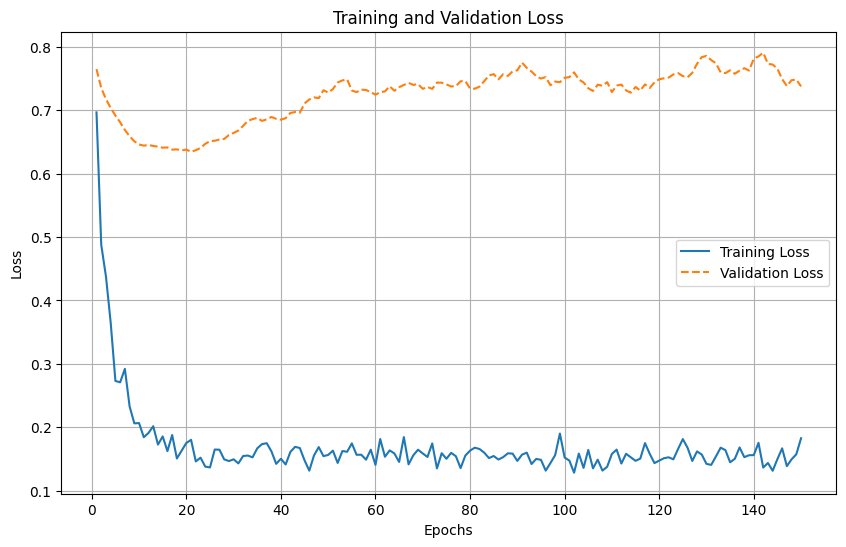

In [ ]:
#%% FINE-TUNE
results = np.zeros((len(fine_tuning_status), len(input_types), len(train_ratios)))
for fine_tuning_stat_idx, fine_tuning_stat in enumerate(fine_tuning_status):
    for input_type_idx, input_type in enumerate(input_types):

        if input_type == "raw" and fine_tuning_stat is not None:
            continue

        selected_patches_idxs = None
        for train_ratio_idx, train_ratio in enumerate(train_ratios):

            print(f"\nfine-tuning status: {fine_tuning_stat}")
            print(f"input type: {input_type}")
            print(f"train ratio: {train_ratio}\n")

            # PREPARE LOADERS
            train_loader, val_loader, samples, target = prepare_loaders(
                preprocessed_data=preprocessed_data,
                labels=labels,
                selected_patches_idxs=selected_patches_idxs,
                input_type=input_type,
                task_type=task_type,
                train_ratio=train_ratio,
                batch_size=128,
                seed=42
            )

            # FINE-TUNE LWM
            fine_tuned_model, best_model_path, train_losses, val_losses, f1_scores, attn_maps_ft = finetune(
                base_model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                task_type=task_type,
                input_type=input_type,
                num_classes=n_beams if task=='Beam Prediction' else 2 if task=='LoS/NLoS Classification' else None,
                output_dim=target.shape[-1] if task_type =='regression' else None,
                use_custom_head=True,
                fine_tune_layers=fine_tuning_stat,
                optimizer_config={"lr": 1e-4},
                epochs=150,
                device=device,
                task=task
            )

            results[fine_tuning_stat_idx][input_type_idx][train_ratio_idx] = f1_scores[-1]

11. Run this if you have selected multiple training ratios.

In [ ]:
markers = ['o', 's', 'D']
labels = ['CLS Emb', 'CHS Emb', 'Raw']
fine_tuning_status_labels = ['No FT', 'Partial FT', 'Full FT']
line_styles = ['-', '--', ':']
colors = plt.cm.viridis(np.linspace(0, 0.8, len(labels)))
plt.figure(figsize=(12, 8), dpi=500)
for ft_idx, (ft_status_label, line_style) in enumerate(zip(fine_tuning_status_labels, line_styles)):
    for idx, (marker, label, color) in enumerate(zip(markers, labels, colors)):
        # For "Raw Channels," only plot "No Fine-Tuning" case
        if label == "Raw" and ft_status_label != "No FT":
            continue
        # Simplify label for "Raw Channels" without fine-tuning
        plot_label = label if label != "Raw Channels" or ft_status_label != "No Fine-Tuning" else "Raw Channels"
        plt.plot(
            train_ratios,
            results[ft_idx, idx],
            marker=marker,
            linestyle=line_style,
            label=f"{plot_label} ({ft_status_label})" if label != "Raw Channels" else plot_label,
            color=color,
            linewidth=3,
            markersize=9
        )
plt.xscale('log')
plt.xlabel("Train Ratio", fontsize=20)
plt.ylabel("F1-Score", fontsize=20)
plt.legend(fontsize=17, loc="best")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()
plt.show()

12. If you have fine-tuned LWM, this cell will show you the fine-tuned embedding space, which will potentially show more well-separated classes.

In [ ]:
#%% 2D EMBEDDING SPACE VISUALIZATIONN AFTER FINE-TUNING
chs = lwm_inference(
    fine_tuned_model.model,
    preprocessed_data,
    input_type="cls_emb",
    device=device,
    batch_size=64,
    visualization=True,
    labels=labels,
    visualization_method=visualization_method)